<a href="https://colab.research.google.com/github/D1emonk/My-repo/blob/main/Lesson_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Подготовка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainloader10 = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True)

trainloader100 = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True)

testloader100 = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform),
    batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:02<00:00, 71.7MB/s]
100%|██████████| 169M/169M [00:03<00:00, 54.3MB/s]


In [5]:
# Определение модели
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [33]:
# Обучение на CIFAR-10
print("Обучение на CIFAR-10")
model = CNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(15):
    running_loss = 0.0
    model.train()
    for inputs, labels in trainloader10:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(inputs), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Эпоха {epoch+1}, Потеря: {running_loss / len(trainloader10):.4f}")

Обучение на CIFAR-10
Эпоха 1, Потеря: 1.3899
Эпоха 2, Потеря: 1.0200
Эпоха 3, Потеря: 0.8457
Эпоха 4, Потеря: 0.7286
Эпоха 5, Потеря: 0.6250
Эпоха 6, Потеря: 0.5325
Эпоха 7, Потеря: 0.4518
Эпоха 8, Потеря: 0.3799
Эпоха 9, Потеря: 0.3283
Эпоха 10, Потеря: 0.2761
Эпоха 11, Потеря: 0.2365
Эпоха 12, Потеря: 0.2083
Эпоха 13, Потеря: 0.1933
Эпоха 14, Потеря: 0.1672
Эпоха 15, Потеря: 0.1526


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import os

In [36]:
# Путь на Google Диске
save_dir = "/content/drive/MyDrive/models"
os.makedirs(save_dir, exist_ok=True)
# Полный путь к файлу
save_path = os.path.join(save_dir, "model_cifar10.pth")
# Сохранение модели
torch.save(model.state_dict(), save_path)

In [61]:
model = CNN(num_classes=10).to(device)

In [62]:
model.load_state_dict(torch.load("/content/drive/MyDrive/models/model_cifar10.pth"))
model.eval()  # Переводим в режим оценки

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [37]:
# Замена выходного слоя
model.fc2 = nn.Linear(256, 100).to(device)

In [38]:
 # Заморозка слоев
for param in model.parameters():
    param.requires_grad = False
for param in model.fc2.parameters():
    param.requires_grad = True

In [39]:
# Новый оптимизатор для дообучения
optimizer = optim.Adam(
    list(model.fc1.parameters()) + list(model.fc2.parameters()), lr=0.001
)

In [40]:
# Разморозка часть сверточных слоёв
for name, param in model.named_parameters():
    if 'conv2' in name or 'fc' in name:
        param.requires_grad = True

In [41]:
# Дообучение только последнего слоя на CIFAR-100
print("Дообучение на CIFAR-100")
for epoch in range(35):
    running_loss = 0.0
    model.train()
    for inputs, labels in trainloader100:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        loss = criterion(model(inputs), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Эпоха {epoch+1}, Потеря: {running_loss / len(trainloader100):.4f}")

Дообучение на CIFAR-100
Эпоха 1, Потеря: 3.3628
Эпоха 2, Потеря: 2.6018
Эпоха 3, Потеря: 2.2740
Эпоха 4, Потеря: 2.0269
Эпоха 5, Потеря: 1.8085
Эпоха 6, Потеря: 1.6278
Эпоха 7, Потеря: 1.4671
Эпоха 8, Потеря: 1.3165
Эпоха 9, Потеря: 1.1932
Эпоха 10, Потеря: 1.0778
Эпоха 11, Потеря: 0.9706
Эпоха 12, Потеря: 0.8851
Эпоха 13, Потеря: 0.8079
Эпоха 14, Потеря: 0.7361
Эпоха 15, Потеря: 0.6817
Эпоха 16, Потеря: 0.6310
Эпоха 17, Потеря: 0.5921
Эпоха 18, Потеря: 0.5522
Эпоха 19, Потеря: 0.5148
Эпоха 20, Потеря: 0.4882
Эпоха 21, Потеря: 0.4635
Эпоха 22, Потеря: 0.4464
Эпоха 23, Потеря: 0.4255
Эпоха 24, Потеря: 0.4004
Эпоха 25, Потеря: 0.3877
Эпоха 26, Потеря: 0.3694
Эпоха 27, Потеря: 0.3641
Эпоха 28, Потеря: 0.3511
Эпоха 29, Потеря: 0.3330
Эпоха 30, Потеря: 0.3325
Эпоха 31, Потеря: 0.3172
Эпоха 32, Потеря: 0.3073
Эпоха 33, Потеря: 0.3021
Эпоха 34, Потеря: 0.2974
Эпоха 35, Потеря: 0.2887


In [42]:
# Сохраняем state_dict (веса модели)
torch.save(model.state_dict(), "/content/drive/MyDrive/models/model_cifar100.pth")

In [53]:
model = CNN(num_classes=100).to(device)

In [54]:
model.load_state_dict(torch.load("/content/drive/MyDrive/models/model_cifar100.pth"))
model.eval()  # Переводим в режим оценки

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=100, bias=True)
)

In [43]:
# === 5. Тестирование на CIFAR-100 ===
print("\n Оценка точности на тесте CIFAR-100")
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for inputs, labels in testloader100:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Точность после Transfer Learning: {accuracy:.2f}%")


 Оценка точности на тесте CIFAR-100
Точность после Transfer Learning: 35.16%


In [44]:
# Функция для получения имени класса по индексу
cifar100_classes = torchvision.datasets.CIFAR100(root='./data', train=False).classes

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy().transpose((1, 2, 0))
    plt.imshow(npimg)

In [45]:
# Визуализация предсказаний
def visualize_predictions(model, dataloader, title, num_images=25):
    model.eval()
    data_iter = iter(dataloader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(5, 5, i+1)
        imshow(images[i])
        plt.axis('off')
        true_label = cifar100_classes[labels[i]]
        pred_label = cifar100_classes[predicted[i]]
        color = 'green' if labels[i] == predicted[i] else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=8, color=color)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [ ]:
# До Transfer Learning
print("\n Визуализация ДО дообучения (CIFAR-100 через модель с 10 классами)")
# Чтобы сравнение было корректным — используем модель ДО подмены слоя
model_before = CNN(num_classes=10).to(device)
model_before.load_state_dict(torch.load("model_cifar10.pth"))  # если сохраняли
visualize_predictions(model_before, testloader100, "До Transfer Learning (ошибки ожидаемы)")

Визуализация ПОСЛЕ Transfer Learning (модель под 100 классов)


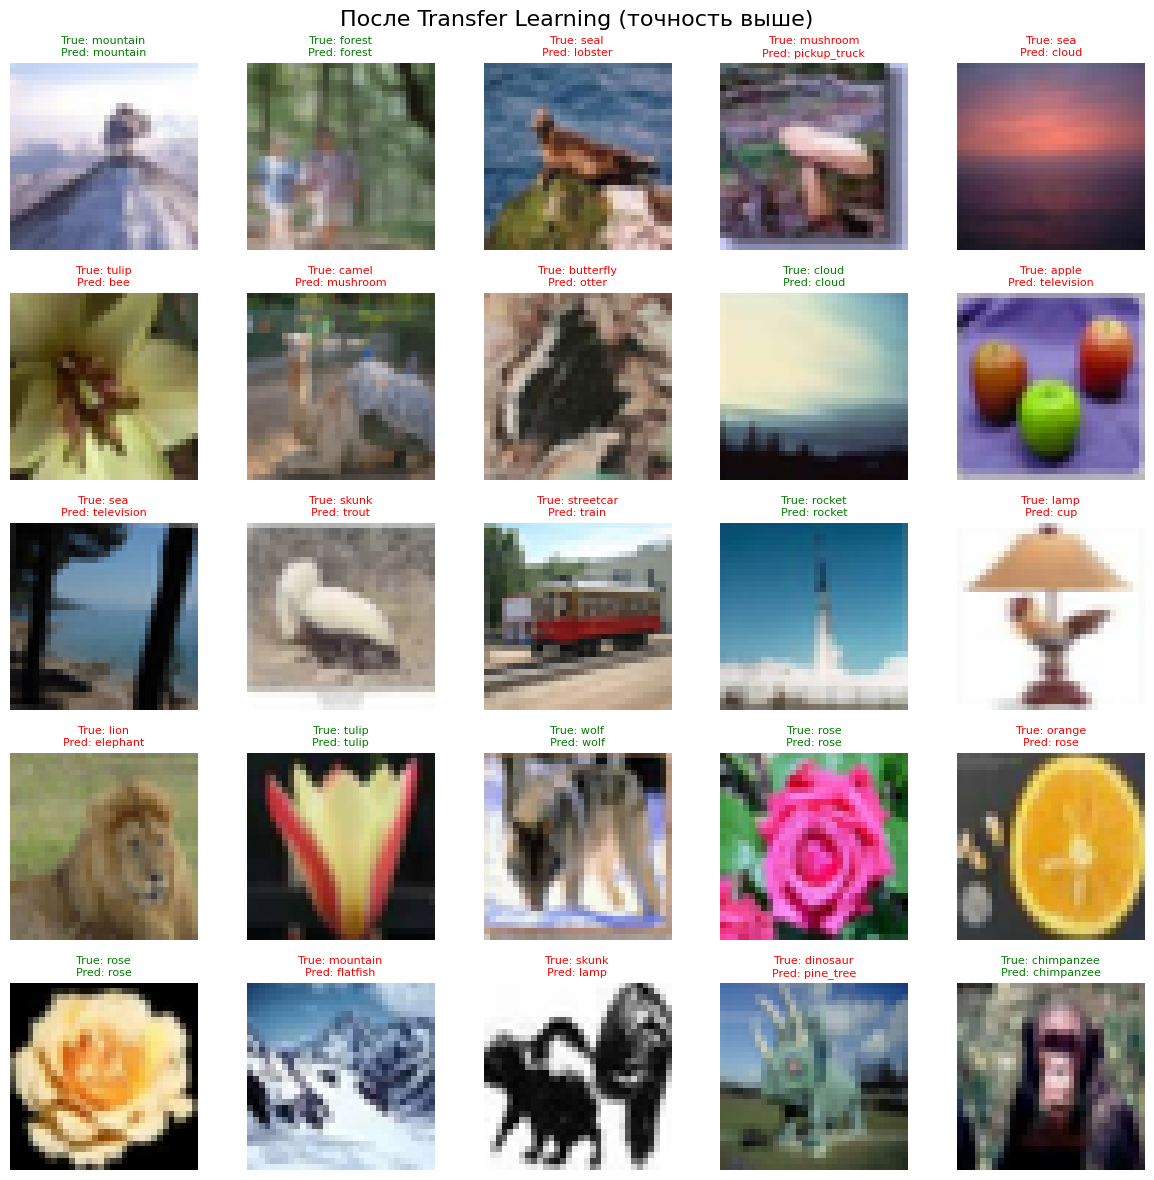

In [57]:
# После Transfer Learning
print("Визуализация ПОСЛЕ Transfer Learning (модель под 100 классов)")
visualize_predictions(model, testloader100, "После Transfer Learning (точность выше)")

In [65]:
# Кастомный трансформер для преобразования изображений в 1D
class FlattenTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.reshape(X.shape[0], -1)

# Конвейер для предобработки изображений
preprocess_pipeline = Pipeline([
    ('flatten', FlattenTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=64)),
])

# Пример использования
images, _ = next(iter(trainloader10))
images_flat = preprocess_pipeline.fit_transform(images.numpy())

In [66]:
# Загружаем один батч данных для примера
images, labels = next(iter(trainloader10))
images_np = images.numpy()

# Применяем конвейер к данным
images_processed = preprocess_pipeline.fit_transform(images_np)


In [68]:
# Визуализация
def plot_images(original, processed, title):
    plt.figure(figsize=(12, 6))

    # Оригинальные изображения
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(original[0], (1, 2, 0)) * 0.5 + 0.5)  # Денормализация
    plt.title("Оригинальное изображение")
    plt.axis('off')

    # После PCA (восстановление из 64 компонентов)
    pca = preprocess_pipeline.named_steps['pca']
    reconstructed = pca.inverse_transform(processed[0:1])  # Восстановление 1 изображения
    reconstructed = reconstructed.reshape(3, 32, 32).transpose(1, 2, 0)
    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed * 0.5 + 0.5)
    plt.title(f"После PCA ({title})")
    plt.axis('off')

    plt.show()


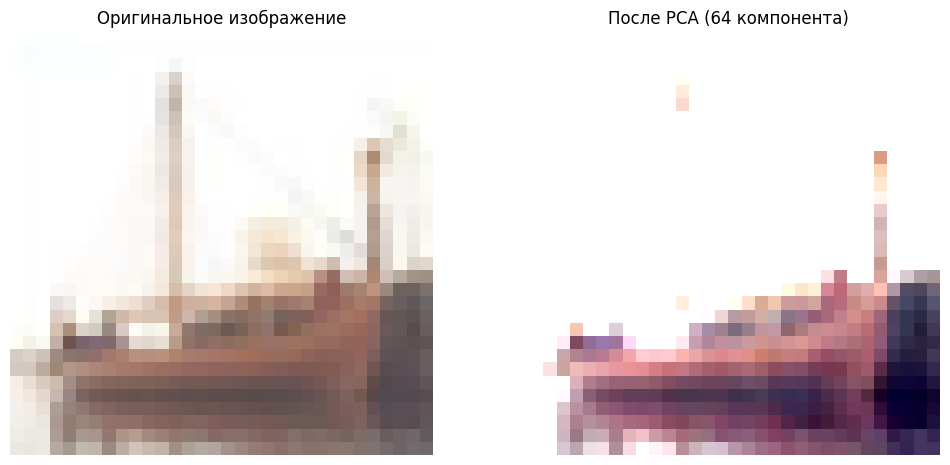

In [70]:
# Выводим результат
plot_images(images_np, images_processed, "64 компонента")